# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("../resources/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fish"
    BACKBONE = 'resnet50'
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 20
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.`
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()

In [4]:
# 获取文件夹中的文件路径
import os
def get_filePathList(dirPath, partOfFileName=''):
    allFileName_list = next(os.walk(dirPath))[2]
    fileName_list = [k for k in allFileName_list if partOfFileName in k]
    filePath_list = [os.path.join(dirPath, k) for k in fileName_list]
    return filePath_list
# 从文本文件中解析出物体种类列表className_list，要求每个种类占一行
def get_classNameList(txtFilePath):
    with open(txtFilePath, 'r', encoding='utf8') as file:
        fileContent = file.read()
        line_list = [k.strip() for k in fileContent.split('\n') if k.strip()!='']
        className_list= sorted(line_list, reverse=False)
    return className_list

In [5]:
class ShapesDataset(utils.Dataset):
    #解析labelme生成的json文件
    def __init__(self, imageFilePath_list):
        super(ShapesDataset, self).__init__()
        self.className_list = get_classNameList('../resources/className_list.txt')
        # Add classes
        for i, className in enumerate(self.className_list, 1):
            self.add_class(source="fish", class_id=i, class_name=className)
        # Add images
        for i, imageFilePath in enumerate(imageFilePath_list):
            jsonFilePath = os.path.splitext(imageFilePath)[0] + '.json'
            self.add_image(source="fish", image_id=i,
                           path=imageFilePath, jsonFilePath=jsonFilePath)

    def load_image(self, image_id):
        info = self.image_info[image_id]
        image = cv2.imread(info['path'])[:,:,::-1]
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        jsonFilePath = info['jsonFilePath']
        with open(jsonFilePath, 'r', encoding='utf8') as file:
            fileContent = file.read()
        json_dict = json.loads(fileContent)
        shapes = json_dict['shapes']
        shape_number = len(shapes)
        image_ndarray = cv2.imread(info['path'])
        height, width, _ = image_ndarray.shape
        mask_ndarray = np.zeros((height, width, shape_number), np.uint8)
        label_list = []
        for i, shape in enumerate(shapes):
            self.draw_mask(mask_ndarray, i, shape, label_list)
        # 把物体种类名称转换为物体种类Id
        classId_list = [self.className_list.index(k) for k in label_list]
        return mask_ndarray.astype(np.bool), np.array(classId_list)
    
    def draw_mask(self, mask_ndarray, i, shape, label_list):
        if 'shape_type' not in shape:
            shapeType = 'polygon'
        else:
            shapeType = shape['shape_type']
        shapeType_list = ['polygon', 'rectangle', 'circle', 'line', 'point', 'linestrip']
        label = shape['label']
        label_list.append(label)
        point_list = shape['points']
        if shapeType not in shapeType_list:
            print('shape have wrong shape_type! please check json file.')
            return 
        elif shapeType == 'polygon' or shapeType == 'line' or shapeType == 'linestrip':
            point_ndarray = np.array(point_list)[np.newaxis, ...]
            mask_ndarray[:, :, i:i+1] = self.draw_fillPoly(mask_ndarray[:, :, i:i+1].copy(), point_ndarray, 128)
        elif shapeType == 'rectangle':
            leftTop_point, rightDown_point = point_list
            mask_ndarray[:, :, i:i+1] = self.draw_rectangle(mask_ndarray[:, :, i:i+1].copy(), leftTop_point, rightDown_point, 128, -1)
        elif shapeType == 'circle':    
            center_point, contour_point = point_list
            center_x ,center_y = center_point
            contour_x, contour_y = contour_point
            radius = int(((center_x - contour_x) ** 2 + (center_y - contour_y) ** 2) ** 0.5)
            mask_ndarray[:, :, i:i+1] = self.draw_circle(mask_ndarray[:, :, i].copy(), tuple(center_point), radius, 128, -1)
        elif shape_type == 'point':
            center_point = point_list[0]
            radius = 3
            mask_ndarray[:, :, i:i+1] = self.draw_circle(mask_ndarray[:, :, i].copy(), tuple(center_point), radius, 128, -1)
    
    def draw_fillPoly(self, mask, point_ndarray, color):
        cv2.fillPoly(mask, point_ndarray, 128)
        return mask
    
    def draw_rectangle(self, mask, leftTop_point, rightDown_point, color, thickness):
        cv2.rectangle(mask, leftTop_point, rightDown_point, color, thickness)
        return mask
    
    def draw_circle(self, mask, center_point, radius, color, thickness):
        cv2.circle(mask, center_point, radius, color, thickness)
        return mask

In [6]:
# 随机划分为3个数据集：训练集，验证集，测试集
def get_train_val_test(dirPath, image_suffix):
    imageFilePath_list = get_filePathList(dirPath, image_suffix)
    np.random.shuffle(imageFilePath_list)
    val_percent, test_percent = 0.05, 0.10
    sample_number = len(imageFilePath_list)
    val_number = max(int(sample_number * val_percent), 1)
    test_number = max(int(sample_number * test_percent), 1)
    train_number = sample_number - val_number - test_number
    print('训练集样本数量:%d，验证集样本数量:%d，测试集样本数量:%d' %(train_number, val_number, test_number))
    train_imageFilePath_list = imageFilePath_list[-train_number : ]
    val_imageFilePath_list = imageFilePath_list[: val_number]
    test_imageFilePath_list = imageFilePath_list[val_number : val_number+test_number]
    train_dataset = ShapesDataset(train_imageFilePath_list)
    val_dataset = ShapesDataset(val_imageFilePath_list)
    test_dataset = ShapesDataset(test_imageFilePath_list)
    train_dataset.prepare()
    val_dataset.prepare()
    test_dataset.prepare()
    return train_dataset, val_dataset, test_dataset

dirPath = '../resources/resized_images_640x640/'
image_suffix = '.jpg'
train_dataset, val_dataset, test_dataset = get_train_val_test(dirPath, image_suffix)
train_dataset.prepare()

训练集样本数量:171，验证集样本数量:9，测试集样本数量:19


图片文件路径: ../resources/resized_images_640x640/121.jpg
掩码矩阵形状: (640, 640, 2)


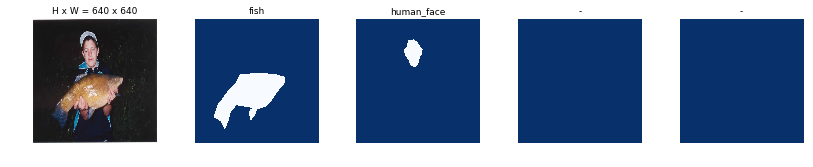

图片文件路径: ../resources/resized_images_640x640/138.jpg
掩码矩阵形状: (640, 640, 2)


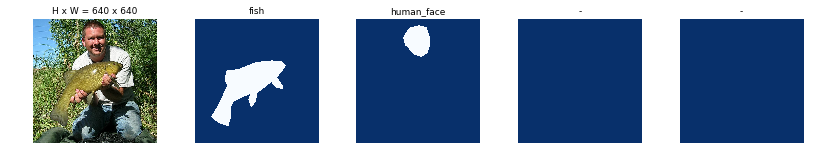

图片文件路径: ../resources/resized_images_640x640/056.jpg
掩码矩阵形状: (640, 640, 2)


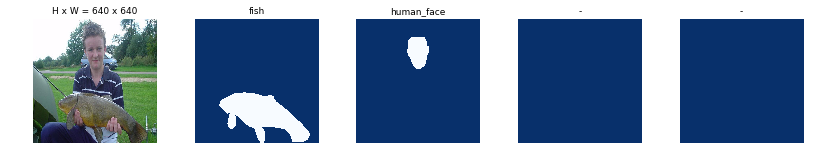

图片文件路径: ../resources/resized_images_640x640/113.jpg
掩码矩阵形状: (640, 640, 1)


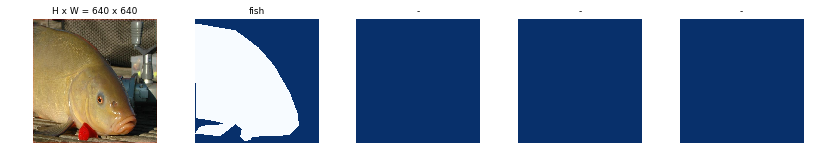

In [7]:
# Load and display random samples
image_ids = np.random.choice(train_dataset.image_ids, 4)
for image_id in image_ids:
    image = train_dataset.load_image(image_id)
    info = train_dataset.image_info[image_id]
    imageFilePath = info['path']
    print('图片文件路径:', imageFilePath)
    mask, classId_list = train_dataset.load_mask(image_id)
    print('掩码矩阵形状:', mask.shape)
    visualize.display_top_masks(image, mask, classId_list, train_dataset.className_list)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Administrator\Desktop\23_git\AI_Projects\002_目标检测实践_keras版Mask-RCNN训练自己的数据\resources\logs\fish20190504T2058\mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
1000/1000 [==============================] - 1067s 1s/step - loss: 1.4487 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 1.0578 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1342 - mrcnn_mask_loss: 0.2073 - val_loss: 1.6101 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 1.2350 - val_mrcnn_class_loss: 0.0253 - val_mrcnn_bbox_loss: 0.1394 - val_mrcnn_mask_loss: 0.2021


In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=50, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\Administrator\Desktop\23_git\AI_Projects\002_目标检测实践_keras版Mask-RCNN训练自己的数据\resources\logs\fish20190504T2058\mask_rcnn_fish_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_bra

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
1000/1000 [==============================] - 1208s 1s/step - loss: 0.3946 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.1170 - val_loss: 1.5612 - val_rpn_class_loss: 0.0079 - val_rpn_bbox_loss: 1.1623 - val_mrcnn_class_loss: 0.0303 - val_mrcnn_bbox_loss: 0.1222 - val_mrcnn_mask_loss: 0.2386


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [13]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\Administrator\Desktop\23_git\AI_Projects\002_目标检测实践_keras版Mask-RCNN训练自己的数据\resources\logs\fish20190504T2058\mask_rcnn_fish_0002.h5
Re-starting from epoch 2


original_image           shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  640.00000  int32
gt_class_id              shape: (2,)                  min:    0.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  126.00000  max:  575.00000  int32
gt_mask                  shape: (640, 640, 2)         min:    0.00000  max:    1.00000  bool


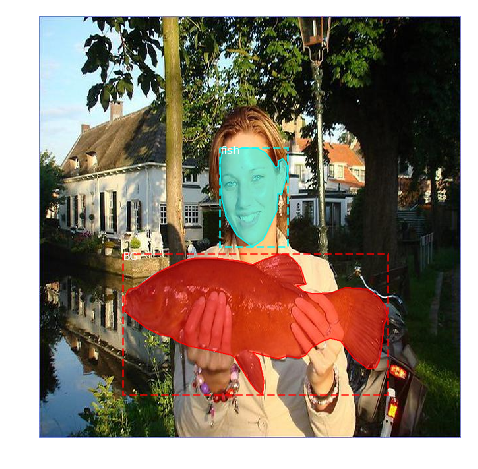

In [31]:
# Test on a random image
image_id = np.random.choice(test_dataset.image_ids, 1)[0]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.14164  max:    1.04149  float32


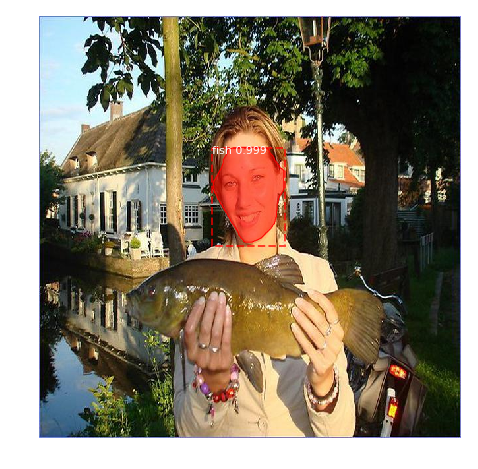

In [32]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_dataset.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))